![Alt text](image-4.png)

![Alt text](image-5.png)

![Alt text](image-6.png)

![Alt text](image-7.png)

![Alt text](image-8.png)

![Alt text](image-9.png)

![Alt text](image-10.png)

![Alt text](image-11.png)

### 목표
    - 버섯의 특징을 활용해 독/식용 버섯을 분류하는 실습을 해보자
    - DecisionTree 분류 모델을 학습하고 시각화 & 과대적합 제어
    - 모델 자체적으로 특성 중요도 선택한 것을 확인해보기

    

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 머신러닝 패키지 -> sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier # 트리분류 모델

### 데이터 불러오기

In [25]:
data = pd.read_csv('data//mushroom.csv')

data
# poisonous 컬럼 : p - 독버섯, e - 식용버섯 (답데이터)
# poisonous 제외한 나머지 컬럼 (문제 데이터)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   poisonous                 8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [26]:
# dataFrame 모든 컬럼을 출력하기
pd.set_option("display.max_columns",None)    # 모든컬럼 출력
data.head(2)

# 데이터 타입 확인하고 실제로 보니깐 모두 문자열이다!
# 머신러닝 모델은 수치화된 데이터만 학습 가능
# 문자 -> 수치 : encoding

,poisonous,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g


### 데이터 전처리 및 탐색
     - 문제(특성)와 답(라벨) 분리
     

In [27]:
# 컬럼 인덱싱
# 답 poisonous, 문제는 답을 제외한 모든 컬럼
X = data.iloc[:,1:]
y = data.iloc[:,0]

# 크기확인
print("문제 데이터", X.shape)
print("답 데이터", y.shape)

np.unique(X,return_counts=True)

문제 데이터 (8124, 22)
답 데이터 (8124,)


(array(['?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n',
        'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'], dtype=object),
 array([ 2480,   994, 12648,  8020,  3148,  9200, 21494,  5896,  2364,
         7784,  2528,   328, 12868,  8080, 18872,   304, 14524,  8584,
          924,  4040, 22906,  3656,  7086], dtype=int64))

In [28]:
# 문제 데이터 기술통계 확인하기
# 최소,최대,중앙,최빈,중앙,평균 ... 등
# 문자형태 -> 최빈값, 어떤게 제일 많이 들었던 알파벳인지
# describe()
X.describe()


,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,6,4,10,2,9,2,2,2,12,2,5,4,4,9,9,1,4,3,5,9,6,7
top,x,y,n,f,n,f,c,b,b,t,b,s,s,w,w,p,w,o,p,w,v,d
freq,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,3776,5176,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


![Alt text](image-12.png)

![Alt text](image-13.png)

In [29]:
# 독성, 식용 각각 몇개씩 들어있을까?
y.value_counts()

poisonous
e    4208
p    3916
Name: count, dtype: int64

- 인코딩(encoding) : 범주(문자) -> 수치
    - 레이블 인코딩(label encoding) : 값의 크고 작음의 의미가 있을때
    - 원핫 인코딩(one - hot encoding) : 값킈 크고 작음의 의미가 없을때

<h3>레이블 인코딩</h3>

![Alt text](image-14.png)

<h3>원핫 인코딩</h>

![Alt text](image-15.png)


In [30]:
# 버섯 데이터 -> 모든 컬럼을 원핫인코딩
# pd.get_dummies(대상) : 원핫인코딩 함수
# 예시 cap-shape 컬럼 1개 적용

# pd. get_dummies(X.iloc[:,:2])
X_oh = pd.get_dummies(X)
# 크기확인
X_oh.shape

(8124, 117)

In [31]:
# 훈련셋, 테스트셋 분리
# 분리 비율 7:3
# 랜덤 섞기는 고정값 3
X_train, X_test, y_train, y_test = train_test_split(X_oh,y,test_size=0.3,random_state=3)

#크기 확인
print("문제데이터", X_train.shape, y_train.shape)
print("답 데이터", X_test.shape,y_test.shape)

문제데이터 (5686, 117) (5686,)
답 데이터 (2438, 117) (2438,)


#### 모델링
    - tree 모델 객체 생성
    - 학습

In [32]:
tree_model =  DecisionTreeClassifier()  # 기본값 그대로 사용

# 트리 모델이 가지를 뻗어나갈 수 있을만큼 최대로 뻗어나감
# 모델이 깊어지는 건 어쩔 수 없다
# 학습 함수 fit(훈련문제, 훈련답)
tree_model.fit(X_train,y_train)



DecisionTreeClassifier()

# 모델의 일반화 성능 확인 - 교차검증
    - 개념 : 일반화 성능 측정 방법 > 모든 데이터에 대해 모델이 얼마나 잘 맞추는지 평가, 한 번 나누는 것보다는 더 안정적인 평가 방법

    - 방법론 : 훈련세트를 기준으로 훈련세트와 검증용 세트로 여러겹 나눠서 평가(새로운 test 데이터를 여러개 만들어 내서 평가)

    - 모델을 정의하고학습하기 전에 정확도가 어느 정도 일지 확인 가능하다




In [33]:
# cross_val_score() : 교차검증하는 도구
from sklearn.model_selection import cross_val_score


In [34]:
# cross_val_score(모델명, 훈련문제, 훈련답, cv=검증횟수(검증데이터 분리되는 횟수))
# scoring --> accuracy(정확도)
result1 = cross_val_score(tree_model,X_train,y_train, cv=5)
result1

# 해당 모델은 버섯 분류에 있어서 과대적합을 제어하지 않아도 성능이 상당히 좋은 상태


array([1.        , 1.        , 1.        , 1.        , 0.99912049])

In [35]:
# X_test 성능 확인
# predict -> 실제값과 비교
# accuacy_Score(실제값, 예측값)
# from sklearn.metrics import accuracy_score  #평가

# pred = tree_model.predict(X_test)
# accuracy_score(y_test,pred) # 예측값 무조건 존재해야함

# 모델이 자체적으로 가지고 있는 score() -> accuracy
test_acc = tree_model.score(X_test,y_test)  # -> accuracy 정확도
test_acc    #100% 맞춘 상태
# 버섯 특징데이터 버서을 잘 분류하기에 좋은 데이터 였음!


1.0

#### 모델이 선택한 중요한 특성확인
    - 특성 선택: 
        - tree 계열의 모델은 특성 중요도를 출력하는 키워드가 있음
        - 모델.feature_importances_

In [36]:
fi = tree_model.feature_importances_
fi  # 과학적 표기법 -> 실수값
# df로 변환

fi_df = pd.DataFrame(fi,index=X_oh.columns,columns=['import'])    # 117개 특성 중요도 수치값
fi_df

# 특성 중요도 내림차순 정려 해보기(top 5)

fi_df.sort_values(ascending=False,by=['import']).head(5)


,import
odor_n,0.616063
stalk-root_c,0.175846
stalk-root_r,0.089786
spore-print-color_r,0.032861
odor_l,0.023063


### tree 모델 시각화
    - 시각화 패키지 설치
    - 1) https://graphviz.org/download/ 파일다운
    - 2) jupyter install > prompt >> pip install graphviz 
                        > jupyter 내부 >> !pip install graphviz

In [37]:
# 주피터 다시 킨 후 cell > RUNALL
from sklearn.tree import export_graphviz

export_graphviz(tree_model,
                out_file ='./tree.dot',
                class_names=['독','식'],
                feature_names=X_oh.columns,
                impurity=False,      #지니 불순도와 비슷한개념
                filled=True)    #해당 노드의 클래스에 대한 색상 지정 

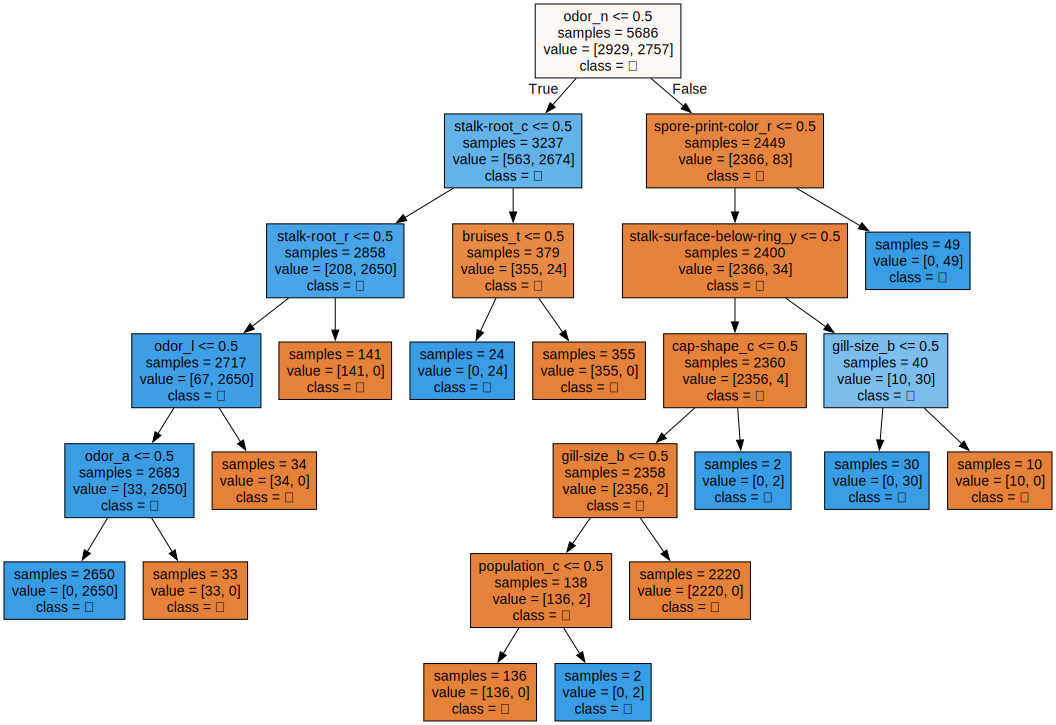

In [38]:
import graphviz
# tree.dot 파일 열어야함
with open('./tree.dot', encoding='UTF8') as f:
    # 읽음
    dot_graph = f.read()
dot_graph
# 그래프 그리기
display(graphviz.Source(dot_graph))

 # 시각화 확인용으로 과대적합 제어해보기
    - max_depth 활용

In [39]:
# tree 모델 객체 생성 - 깊이 3
tree_model2 = DecisionTreeClassifier(max_depth=3)

tree_model2.fit(X_train,y_train)


DecisionTreeClassifier(max_depth=3)

In [40]:
export_graphviz(tree_model2,
                out_file ='./tree2.dot',
                class_names=['독','식'],
                feature_names=X_oh.columns,
                impurity=False,   
                filled=True)  

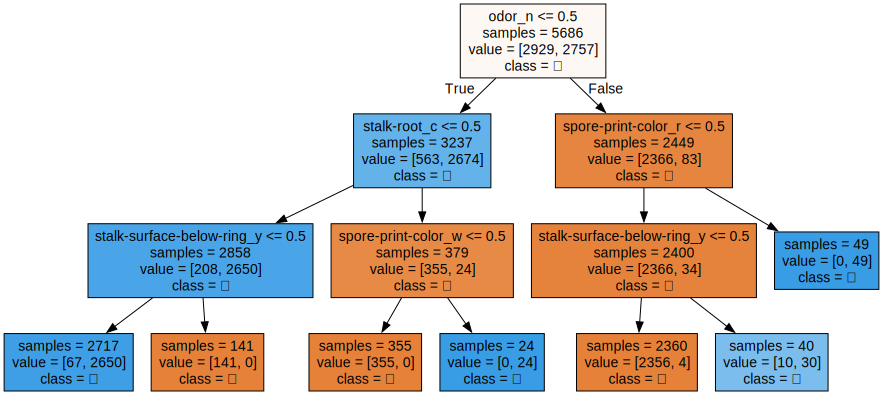

In [41]:
with open('./tree2.dot', encoding='UTF8') as f:
    # 읽음
    dot_graph = f.read()
dot_graph
# 그래프 그리기
display(graphviz.Source(dot_graph))